*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Assignment 2 - Yelp  </center>
<center> Karl Hendrik Nurmeots, February 19, 2020 </center>



***

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from haversine import haversine, Unit
import seaborn as sns
import simplejson as json
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon, mapping, shape, LineString
from shapely.ops import polygonize
import re
from fuzzywuzzy import fuzz
from sklearn.linear_model import LinearRegression
import string
import contextily as ctx
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.wkt import loads
import scipy as scp
from typing import Tuple
from functools import partial
import pyproj
import shapely.ops as ops

In [3]:
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15,7]

# Introduction

[Yelp](https://www.yelp.com/) is a business directory service and crowd-sourced review forum.

# The Yelp Dataset

For this report we will be using the [Yelp dataset](https://www.yelp.com/dataset/challenge). **For this report to compile, you must download the data from the website and place it in extracted form in the 'data' directory!**. This requires you to provide your email and name.

Per the [Yelp dataset license](https://s3-media1.fl.yelpcdn.com/assets/srv0/engineering_pages/06cb5ad91db8/assets/vendor/yelp-dataset-agreement.pdf), one is allowed to create a report of the data such as this one only for academic purposes. Any sort of disclosure or sharing of the dataset itself is strictly prohibited - this is a private dataset. Any use of the dataset must not disparage Yelp.

A more detailed overview of the dataset can be found on the [dataset documentation page](https://www.yelp.com/dataset/documentation/main). Due to the comprehensive extent of the dataset we will only provide a short insight into what the dataset contains. The dataset consists of 6 JSON files: 

`business.json` contains information about each establishment in the dataset such as the business' name, ID, location (address and coordinates), Yelp rating and review count, attributes (e.g. if the business provides a takeout service), category, and opening hours.

`review.json` contains information about each review, namely the author ID, business reviewed ID, rating, date, full review text, and the number of "useful", "funny" and "cool" votes the review has recieved. Author ID maps to the corresponding user in user.json, and business ID maps to the business in business.json.

`user.json` contains information about users' IDs, first names, their friends' user IDs, and info about the feedback they have recieved on their reviews (e.g. total "useful" votes).

`checkin.json` contains each business' ID and a collection of timestamps when users have checked in at that business. Again, the business ID maps to business.json.

`tip.json` contains information about short tips that users have posted, and is structured similarly to review.json. Tips are essentially very short reviews, but do not give a numeric rating about the business. Instead of tracking the number of different votes, the number of "compliments" the tip has recieved is tracked.

`photo.json` contains metadata about photos users have posted: the business' ID the picture is about, the author's user ID, the picture's caption and label (e.g. "food"). 

For this analysis, we will only use `business.json` and `review.json`.

In [4]:
def json_to_dataframe(file: str, nrows = 0) -> pd.DataFrame:
    """Returns a Pandas dataframe from the JSON file located at <file>."""
    with open(file, 'r', encoding="utf8") as f:
        if nrows == 0:
            content = f.readlines()
        else:
            content = []
            for i in range(nrows):
                content.append(f.readline())
        
    return pd.DataFrame([json.loads(row) for row in content])

In [5]:
# Reading in the 2 JSON files
business = json_to_dataframe("data/business.json")
review = json_to_dataframe("data/review.json", 500)

# The coordinates in the dataset are too precise and would cause computational issues later on,
# so we will round them. With 4 decimal points the coordinates are still precise enough to locate
# buildings.
business.latitude = business.apply(lambda row: round(row.latitude, 5), axis=1)
business.longitude = business.apply(lambda row: round(row.longitude, 5), axis=1)

In [6]:
business

business_id                             name  \
0       1SWheh84yJXfytovILXOAQ       Arizona Biltmore Golf Club   
1       QXAEGFB4oINsVuTFxEYKFQ       Emerald Chinese Restaurant   
2       gnKjwL_1w79qoiV3IC_xQQ      Musashi Japanese Restaurant   
3       xvX2CttrVhyG2z1dFg_0xw  Farmers Insurance - Paul Lorenz   
4       HhyxOkGAM07SRYtlQ4wMFQ              Queen City Plumbing   
...                        ...                              ...   
192604  nqb4kWcOwp8bFxzfvaDpZQ               Sanderson Plumbing   
192605  vY2nLU5K20Pee-FdG0br1g                         Chapters   
192606  MiEyUDKTjeci5TMfxVZPpg                   Phoenix Pavers   
192607  zNMupayB2jEHVDOji8sxoQ            Beasley's Barber Shop   
192608  c1f_VAX1KIK8-JoVhjbYOw                   Oriental Relax   

                               address             city state postal_code  \
0          2818 E Camino Acequia Drive          Phoenix    AZ       85016   
1                 30 Eglinton Avenue W      Mississauga    ON     L5R 3E7   
2            10110 Johnston Rd, Ste 15        Charlotte    NC       28210   
3        15655 W Roosevelt St, Ste 237         Goodyear    AZ       85338   
4       4209 Stuart Andrew Blvd, Ste F        Charlotte    NC       28217   
...                                ...              ...   ...         ...   
192604                                  North Las Vegas    NV       89032   
192605              17440 Yonge Street        Newmarket    ON     L3Y 6Y9   
192606                 21230 N 22nd St          Phoenix    AZ       85024   
192607                  4406 E Main St             Mesa    AZ       85205   
192608           3735 S Las Vegas Blvd        Las Vegas    NV       89109   

        latitude  longitude  stars  review_count  is_open  \
0       33.52214 -112.01848    3.0             5        0   
1       43.60550  -79.65229    2.5           128        1   
2       35.09256  -80.85913    4.0           170        1   
3       33.45561 -112.39560    5.0             3        1   
4       35.19001  -80.88722    4.0             4        1   
...          ...        ...    ...           ...      ...   
192604  36.21373 -115.17706    5.0             9        1   
192605  44.05266  -79.48185    4.5             3        1   
192606  33.67999 -112.03557    4.5            14        1   
192607  33.41614 -111.73574    4.5            15        1   
192608  36.10727 -115.17192    4.0             3        0   

                                               attributes  \
0                                {'GoodForKids': 'False'}   
1       {'RestaurantsReservations': 'True', 'GoodForMe...   
2       {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...   
3                                                    None   
4       {'BusinessAcceptsBitcoin': 'False', 'ByAppoint...   
...                                                   ...   
192604             {'BusinessAcceptsCreditCards': 'True'}   
192605  {'RestaurantsPriceRange2': '2', 'BikeParking':...   
192606  {'BusinessAcceptsCreditCards': 'True', 'ByAppo...   
192607  {'RestaurantsPriceRange2': '1', 'BusinessAccep...   
192608  {'BikeParking': 'False', 'RestaurantsPriceRang...   

                                               categories  \
0                                       Golf, Active Life   
1       Specialty Food, Restaurants, Dim Sum, Imported...   
2                       Sushi Bars, Restaurants, Japanese   
3                           Insurance, Financial Services   
4       Plumbing, Shopping, Local Services, Home Servi...   
...                                                   ...   
192604  Water Purification Services, Water Heater Inst...   
192605               Books, Mags, Music & Video, Shopping   
192606  Home Services, Contractors, Landscaping, Mason...   
192607                             Beauty & Spas, Barbers   
192608                             Massage, Beauty & Spas   

                                                    hours  
0                             

# Analysis

Oddly enough, the dataset does not contain information about what country each business is located in, so to start off, let's visualize all of our businesses on a world map. For this and all following map visualizations we will be using the Mercator projection.

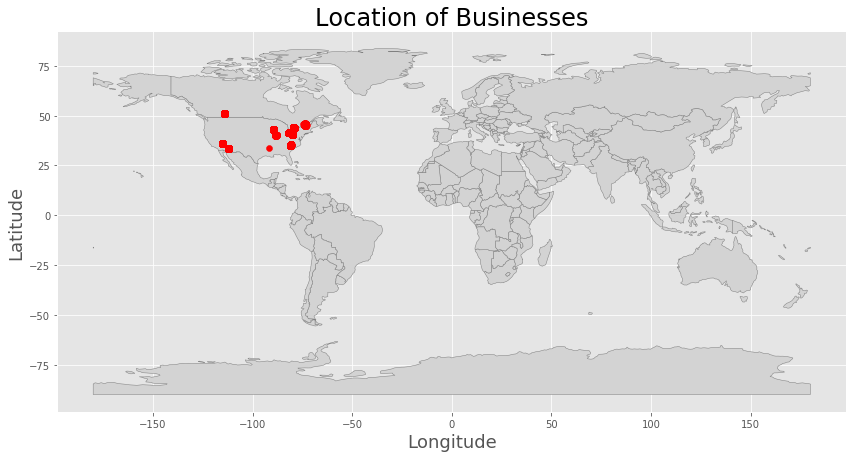

In [7]:
# Get world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Create GeoDataFrame for business
gdf = gpd.GeoDataFrame(
    business, geometry=gpd.points_from_xy(business.longitude, business.latitude), crs=world.crs)

ax = world.plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red')

plt.title("Location of Businesses", fontsize=24)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)
plt.show()

All of the businesses in the dataset are located either in the US or Canada. We have information about the businesses' postal codes, and we can notice that USA and Canada have different postal code formats: US postal codes include only numbers, while Canadian ones always include alphabetic letters, so we can easily create a new column `country` to distinguish the country the business is located in based on their postal code.

In [8]:
def get_country(row: pd.Series) -> str:
    """Given a Pandas series representing a row about a business, returns the country
       the business is located in.
       
       Note that postal codes in Canada always contain letters, while US postal codes do not."""
    
    if re.search('[a-zA-Z]', row.postal_code) is None:
        return "USA"
    return "Canada"

business['country'] = business.apply(lambda row: get_country(row), axis=1)

Let's see how the businesses in the dataset distribute in terms of the country they are located in:

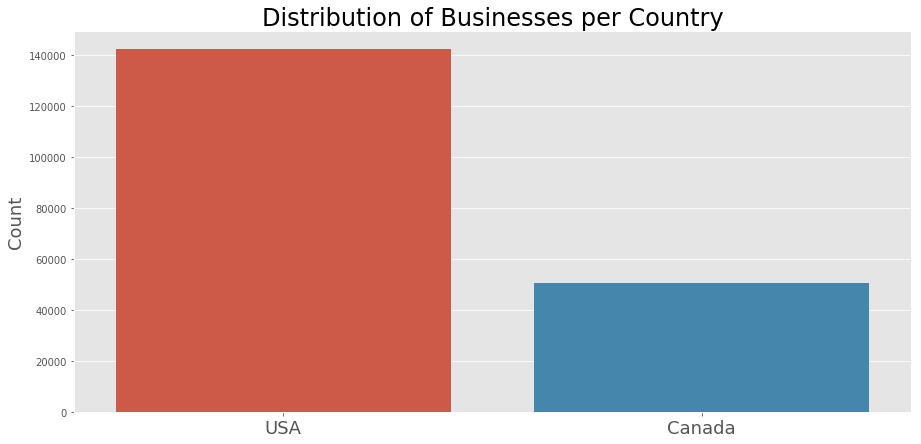

In [9]:
sns.countplot(x=business.country)

plt.title("Distribution of Businesses per Country", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=18)
plt.show()

We can see that over 70% of the businesses in the dataset are located in the US.

Moving on, we would like to see how the businesses distribute across cities in the dataset. When we take a look at the different cities present in the dataset, however, we will realise that there are many inconsistencies in the city names: for example, both "Montréal" and "Montreal" show up.

We would like to fix this issue, so we will use FuzzyWuzzy, a fuzzy string matching package. Our businesses dataset is very large, and this type of string fixing is very demanding, so we will have to compromise: we will only try to fix the names of the largest 100 cities in the US and Canada (separately). A quick glimpse into the data tells us that most businesses are located in these cities, so it is also more likely that there are inconsistencies in the city names for these businesses.

More precisely, we will look at the biggest cities by population based on Wikipedia. Here's our reference data: [Canada](https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population) and [USA](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population).

In [10]:
url_ca = 'https://en.wikipedia.org/wiki/List_of_the_100_largest_municipalities_in_Canada_by_population'
url_usa = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

canada = pd.read_html(url_ca, attrs = {"class":"wikitable sortable"})[0]
canada_cities = canada.Municipality.values

usa = pd.read_html(url_usa, attrs = {"class":"wikitable sortable"})[0]
usa_cities = usa.City.values[:100]

# Reading in the USA cities data sometimes adds weird tags to the city names, so we will
# remove them.
for i in range(len(usa_cities)):
    usa_cities[i] = re.sub('\[.\]$', '', usa_cities[i])

In [11]:
def fix_city_name(row: pd.Series) -> str:
    """Given a Pandas Series representing a row about a business,
       returns the fuzzy corrected city name for that business."""
    city = row.city
    cutoff = 90
    
    # If we get a match of >= cutoff %, return that match.
    # Otherwise, return the original city name.
    if row.country == 'Canada':
        for ca in canada_cities:
            if fuzz.token_set_ratio(city, ca) >= cutoff:
                return ca
    else:
        for us in usa_cities:
            if fuzz.token_set_ratio(city, us) >= cutoff:
                return us
    return city

business['city'] = business.apply(lambda row: fix_city_name(row), axis=1)

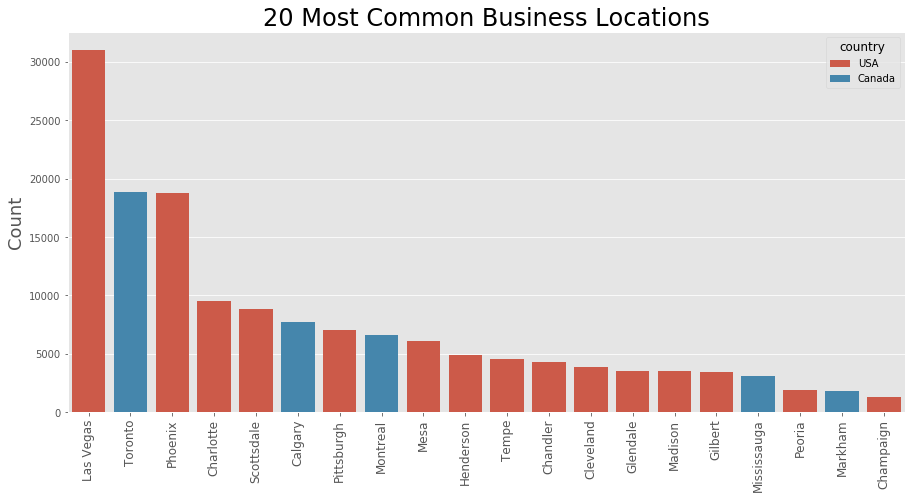

In [12]:
sns.countplot(business.city, order=business.city.value_counts().iloc[:20].index,
             hue=business.country, dodge=False)

plt.xticks(rotation=90)
plt.title("20 Most Common Business Locations", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)

plt.show()

In total, there are just over 1000 different cities in the dataset, however the businesses in the top 20 most common cities account for about 78% of all the businesses in the dataset. As evident, this list is dominated by cities in the US, accompanied by some of the biggest cities in Canada. The most common city in the dataset is Las Vegas, which accounts for about 15% of all businesses.

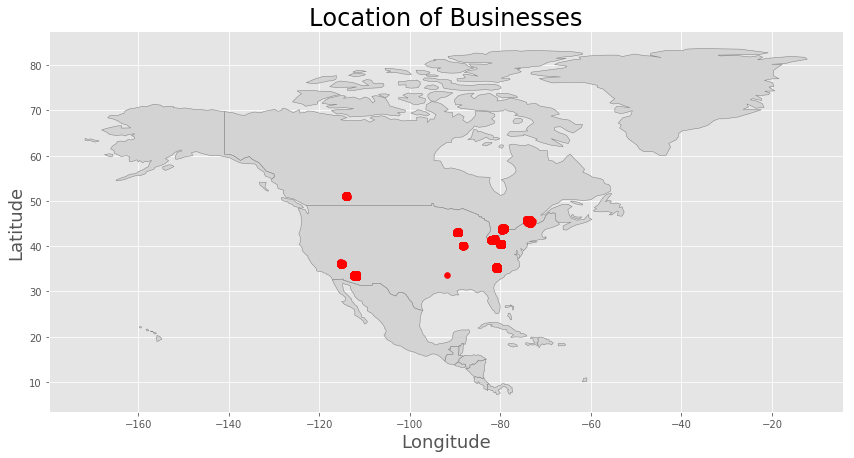

In [13]:
ax = world[world.continent=='North America'].plot(
    color='lightgrey', edgecolor='grey')

gdf.plot(ax=ax, color='red', alpha=1)

plt.title("Location of Businesses", fontsize=24)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)
plt.show()

When we map the location of businesses, we can see that the dataset contains businesses from very few regions: most of them are clustered together in the east US and GTA area, with some others situated in the southwestern parts of the US and Canada.

In [14]:
business.attributes.values

array([{'GoodForKids': 'False'},
       {'RestaurantsReservations': 'True', 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}", 'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}", 'Caters': 'True', 'NoiseLevel': "u'loud'", 'RestaurantsTableService': 'True', 'RestaurantsTakeOut': 'True', 'RestaurantsPriceRange2': '2', 'OutdoorSeating': 'False', 'BikeParking': 'False', 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}", 'HasTV': 'False', 'WiFi': "u'no'", 'GoodForKids': 'True', 'Alcohol': "u'full_bar'", 'RestaurantsAttire': "u'casual'", 'RestaurantsGoodForGroups': 'True', 'RestaurantsDelivery': 'False'},
       {'GoodForKids': 'True', 'NoiseLevel': "u'average'", 'RestaurantsDelivery': 'False', 'GoodForMeal': "{'dessert': False, 'latenight': Fa

### Business Categories

We would like to analyse what categories of businesses are present in the dataset. The dataset has a column `categories`, which contains usually multiple tags for each business. The data is not well formatted: for example, the most common value in `categories` is "Restaurants, Pizza", while the third most common value is "Pizza, Restaurants". Because of all of the different possible tags and their permutations, we need to reduce the number of categories to get a better overview of what's going on.

In [15]:
cat = pd.DataFrame(business.categories.value_counts())
cat = cat.reset_index()
cat.columns = ['category', 'count']
sum(cat[:5000]['count'])

95880

In [16]:
business.head()

business_id                             name  \
0  1SWheh84yJXfytovILXOAQ       Arizona Biltmore Golf Club   
1  QXAEGFB4oINsVuTFxEYKFQ       Emerald Chinese Restaurant   
2  gnKjwL_1w79qoiV3IC_xQQ      Musashi Japanese Restaurant   
3  xvX2CttrVhyG2z1dFg_0xw  Farmers Insurance - Paul Lorenz   
4  HhyxOkGAM07SRYtlQ4wMFQ              Queen City Plumbing   

                          address         city state postal_code  latitude  \
0     2818 E Camino Acequia Drive      Phoenix    AZ       85016  33.52214   
1            30 Eglinton Avenue W  Mississauga    ON     L5R 3E7  43.60550   
2       10110 Johnston Rd, Ste 15    Charlotte    NC       28210  35.09256   
3   15655 W Roosevelt St, Ste 237     Goodyear    AZ       85338  33.45561   
4  4209 Stuart Andrew Blvd, Ste F    Charlotte    NC       28217  35.19001   

   longitude  stars  review_count  is_open  \
0 -112.01848    3.0             5        0   
1  -79.65229    2.5           128        1   
2  -80.85913    4.0           170        1   
3 -112.39560    5.0             3        1   
4  -80.88722    4.0             4        1   

                                          attributes  \
0                           {'GoodForKids': 'False'}   
1  {'RestaurantsReservations': 'True', 'GoodForMe...   
2  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...   
3                                               None   
4  {'BusinessAcceptsBitcoin': 'False', 'ByAppoint...   

                                          categories  \
0                                  Golf, Active Life   
1  Specialty Food, Restaurants, Dim Sum, Imported...   
2                  Sushi Bars, Restaurants, Japanese   
3                      Insurance, Financial Services   
4  Plumbing, Shopping, Local Services, Home Servi...   

                                               hours  \
0                                               None   
1  {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...   
2  {'Monday': '17:30-21:30', 'Wednesday': '17:30-...   
3  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
4  {'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...   

                      geometry country  
0  POINT (-112.01848 33.52214)     USA  
1   POINT (-79.65229 43.60550)  Canada  
2   POINT (-80.85913 35.09256)     USA  
3  POINT (-112.39560 33.45561)     USA  
4   POINT (-80.88722 35.19001)     USA

In [17]:
keywords = {}

for i, bus in business.iterrows():
    cat = bus.categories
    att = bus.attributes
    if cat is not None:
        for word in cat.split(','):
            if word.strip() in keywords:
                keywords[word.strip()][0] += 1
            else:
                keywords[word.strip()] = [1, 0]
        
            if att is not None and 'BikeParking' in att and att['BikeParking'] == 'True':
                keywords[word.strip()][1] += 1

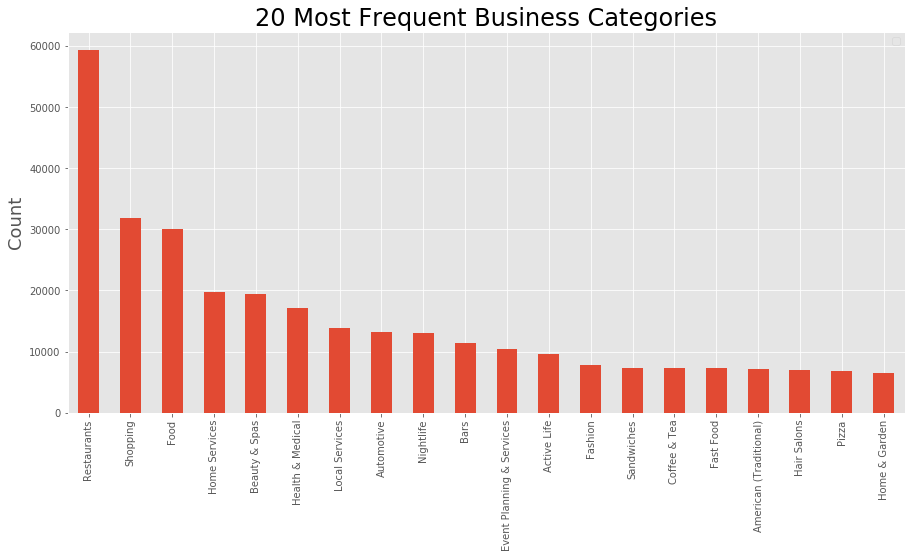

In [18]:
cats = pd.DataFrame.from_dict(keywords, orient='index')
cats = cats.reset_index()
cats.columns = ['category', 'count', 'bike_parking']
cats['prop_bike_parking'] = cats.apply(lambda row: 100*row.bike_parking/row['count'], axis=1)
topcats = cats.sort_values('count', ascending=False).head(20)


topcats.plot.bar(x='category', y='count', label='')

plt.title("20 Most Frequent Business Categories", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.legend("")
plt.show()

For the most part, this sort of splitting works: most of the categories we are left with are "general" as they describe a very broad category of business. However, we can still see that there's likely some overlap: "Food", "Sandwiches", "Fast Food" and others could be considered subsets of "Restaurants". At the same time, not every business with the tag "Fast Food" is also tagged with "Restaurants", so in many cases there is no overlap. Because of the great number of different categories it is extremely difficult to come up with a successful way of reducing the categories, so we will simply have to keep this in mind and look at the categories critically.

Also, some of these tags can be very vague: notice "American (Traditional)", for example. Without any context it is difficult to say what sort of business this tag represents - or perhaps it is supposed to be a vague tag, which is meant to be accompanied by other tags to provide context. Most certainly, saying that "There are fewer than 10 000 American businesses in the dataset" is wrong - as previously shown, most of the dataset is composed of businesses located in the US, and can hence be considered American.

Despite these limitations we can still observe many interesting things. Businesses in the food industry are most frequent in the dataset. Besides this, while there are some categories indicating retail businesses (e.g. "Shopping"), the list of most frequent categories with food industry excluded is dominated by businesses providing services (e.g. "Home Services", "Beauty & Spas", "Health & Medical").

### Bike Parking

We would like to know what types of businesses tend to have bike parking. In the dataset, the column `attributes` contains various attributes relating to each business. One of them is 'BikeParking', which can evaluate to true or false.

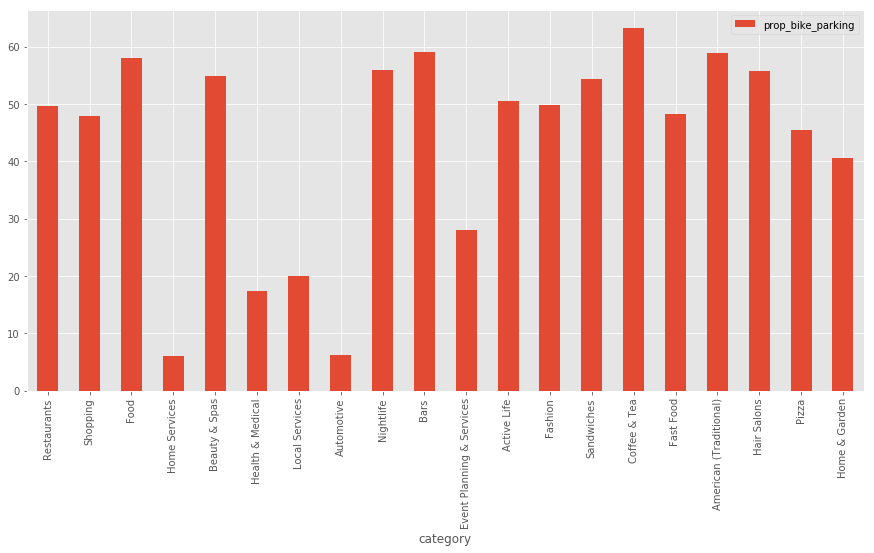

In [19]:
topcats.plot.bar(x='category', y='prop_bike_parking')

In [20]:
topbike = topcats = cats[cats['count'] >= 10].sort_values('prop_bike_parking', ascending=False).head(20)
topbike.head(10)

category  count  bike_parking  prop_bike_parking
1145          Baseball Fields     14            14         100.000000
203              Beer Gardens     80            69          86.250000
705         Basketball Courts     17            14          82.352941
205   Bike Repair/Maintenance    284           233          82.042254
786             Rock Climbing     33            27          81.818182
697           Ethical Grocery     21            17          80.952381
670             Vinyl Records    140           112          80.000000
724            Used Bookstore     30            24          80.000000
466           Mountain Biking     82            65          79.268293
734        Threading Services    279           220          78.853047

### Relationship Between Rating Count and Value



In [21]:
business.head()

business_id                             name  \
0  1SWheh84yJXfytovILXOAQ       Arizona Biltmore Golf Club   
1  QXAEGFB4oINsVuTFxEYKFQ       Emerald Chinese Restaurant   
2  gnKjwL_1w79qoiV3IC_xQQ      Musashi Japanese Restaurant   
3  xvX2CttrVhyG2z1dFg_0xw  Farmers Insurance - Paul Lorenz   
4  HhyxOkGAM07SRYtlQ4wMFQ              Queen City Plumbing   

                          address         city state postal_code  latitude  \
0     2818 E Camino Acequia Drive      Phoenix    AZ       85016  33.52214   
1            30 Eglinton Avenue W  Mississauga    ON     L5R 3E7  43.60550   
2       10110 Johnston Rd, Ste 15    Charlotte    NC       28210  35.09256   
3   15655 W Roosevelt St, Ste 237     Goodyear    AZ       85338  33.45561   
4  4209 Stuart Andrew Blvd, Ste F    Charlotte    NC       28217  35.19001   

   longitude  stars  review_count  is_open  \
0 -112.01848    3.0             5        0   
1  -79.65229    2.5           128        1   
2  -80.85913    4.0           170        1   
3 -112.39560    5.0             3        1   
4  -80.88722    4.0             4        1   

                                          attributes  \
0                           {'GoodForKids': 'False'}   
1  {'RestaurantsReservations': 'True', 'GoodForMe...   
2  {'GoodForKids': 'True', 'NoiseLevel': 'u'avera...   
3                                               None   
4  {'BusinessAcceptsBitcoin': 'False', 'ByAppoint...   

                                          categories  \
0                                  Golf, Active Life   
1  Specialty Food, Restaurants, Dim Sum, Imported...   
2                  Sushi Bars, Restaurants, Japanese   
3                      Insurance, Financial Services   
4  Plumbing, Shopping, Local Services, Home Servi...   

                                               hours  \
0                                               None   
1  {'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...   
2  {'Monday': '17:30-21:30', 'Wednesday': '17:30-...   
3  {'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...   
4  {'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...   

                      geometry country  
0  POINT (-112.01848 33.52214)     USA  
1   POINT (-79.65229 43.60550)  Canada  
2   POINT (-80.85913 35.09256)     USA  
3  POINT (-112.39560 33.45561)     USA  
4   POINT (-80.88722 35.19001)     USA

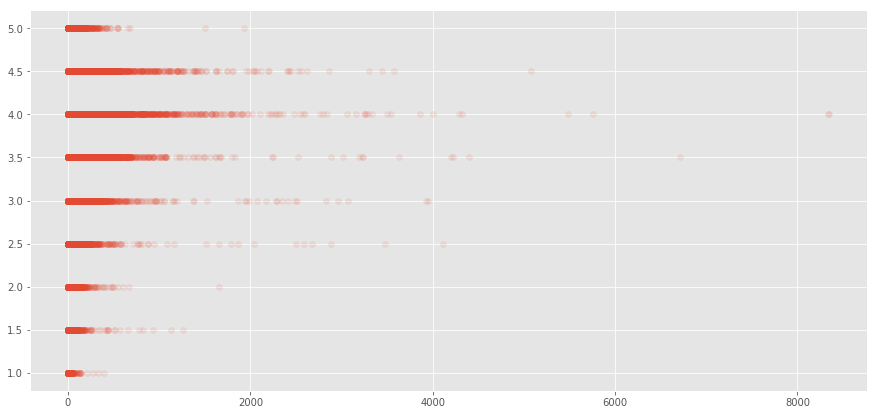

In [22]:
fig, ax = plt.subplots()

ax.scatter(x=business.review_count, y=business.stars, alpha=0.1)

In [23]:
# Create linear regression model
x = np.array(business.review_count).reshape((-1,1))
y = np.array(business.stars)
    
reg = LinearRegression().fit(x, y)

In [24]:
reg.score(x,y)

0.0016668763525098387

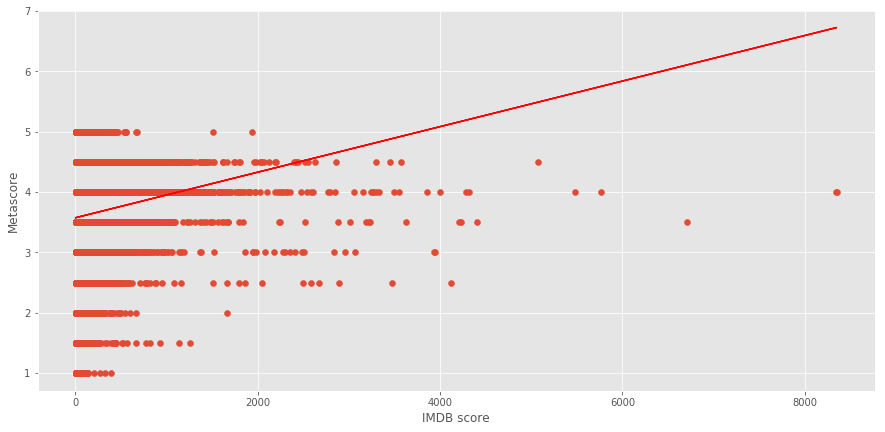

In [25]:
plt.scatter(x, y)
plt.plot(x, reg.predict(x),color='r')
plt.xlabel("IMDB score")
plt.ylabel("Metascore")

plt.show()

## Businesses in the GTA

For this section we are interested in businesses situated in the Greater Toronto Area (GTA). People's definition of which municipalities are contained within the GTA varies, so we will be using the list of cities given in the relevant [Wikipedia article](https://en.wikipedia.org/wiki/Greater_Toronto_Area).

In [26]:
gta_cities = ['Toronto', 'Ajax', 'Clarington', 'Brock', 'Oshawa', 'Pickering', 'Scugog',
              'Uxbridge', 'Whitby', 'Burlington', 'Halton Hills', 'Milton', 'Oakville',
              'Brampton', 'Caledon', 'Mississauga', 'Aurora', 'East Gwilimbury', 'Georgina',
              'King', 'Markham', 'Newmarket', 'Richmond Hill', 'Vaughan', 'Whitchurch-Stouffville']

# We are checking the country too since the US and Canada do share many city names
gta = business[(business.country == "Canada") & (business.city.isin(gta_cities))]

### Top Franchises in the GTA

We would like to know what are the most common franchises in the GTA. Before we can start this analysis, we realise that the same issue we had with city names shows up again: there are inconsistencies in business names. For example, both "Tim Hortons" and "Tim Horton's" are present in the dataset.

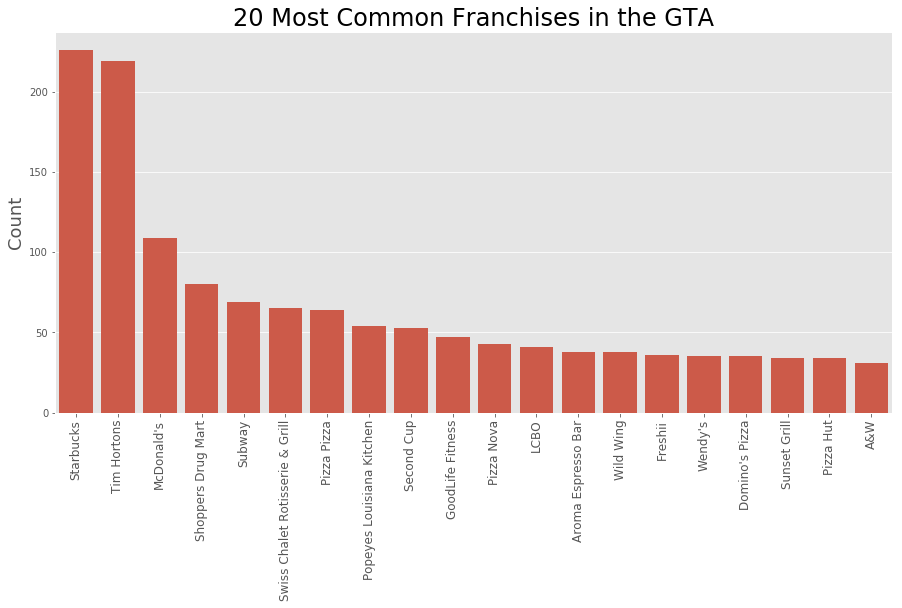

In [27]:
gta = gta.replace("Tim Horton's", "Tim Hortons")

sns.countplot(gta.name, order=gta.name.value_counts().iloc[:20].index, color='C0')

plt.xticks(rotation=90)
plt.title("20 Most Common Franchises in the GTA", fontsize=24)
plt.ylabel("Count", fontsize=18)
plt.xlabel("")
plt.xticks(fontsize=12)

plt.show()

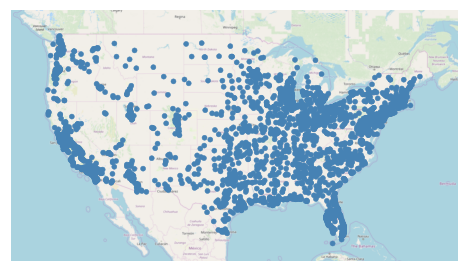

In [28]:
continental_usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
continental_usa_cities = continental_usa_cities.query('STATE not in ["AK", "HI", "PR"]')
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator())
gplt.pointplot(continental_usa_cities, ax=ax)

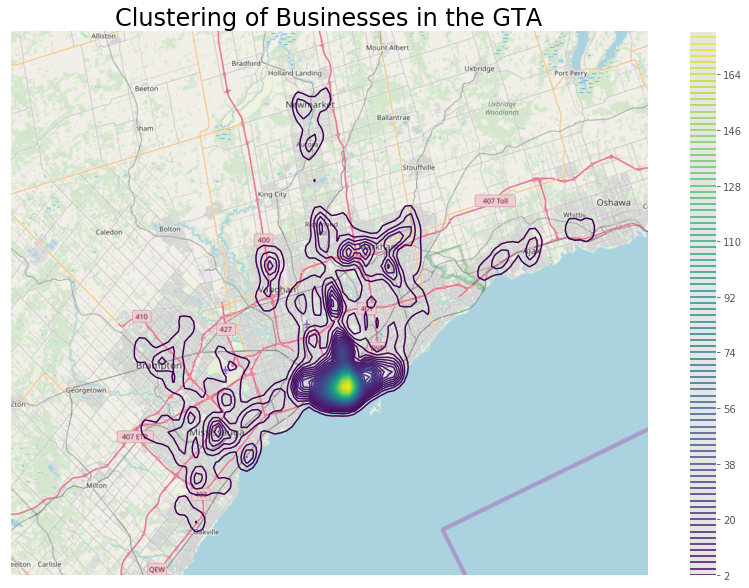

In [30]:
#toronto = gpd.read_file("data/on_roads.json")

# Create GeoDataFrame for businesses in the GTA
gdf_gta = gdf[(gdf.country == "Canada") & (gdf.city.isin(gta_cities))]
gdf_gta.to_crs(epsg=3857)

ax = gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.kdeplot(gdf_gta, ax=ax, n_levels=100, cbar=True, cbar_kws = {"extend": 'neither', 'drawedges': True})

plt.title("Clustering of Businesses in the GTA", fontsize=24)
plt.show()

ValueError: Colormap <matplotlib.cm.ScalarMappable object at 0x0000027063F62978> is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

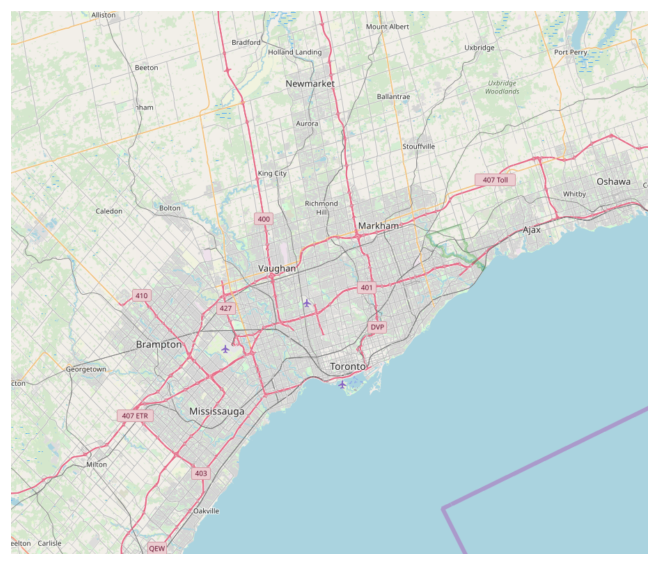

In [31]:
ax = gplt.webmap(gdf_gta, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.kdeplot(gdf_gta, ax=ax, n_levels=100, cmap='Reds', hue=gdf_gta.stars, cbar=True, cbar_kws = {"extend": 'neither', 'drawedges': True})

plt.title("Clustering of Businesses in the GTA", fontsize=24)
plt.show()

In [ ]:
gplt.quadtree(gdf_gta, nmin=100)

plt.show()

### Tim Hortons and Starbucks

In [32]:
coffee = gta[(gta['name'] == 'Tim Hortons') | (gta['name'] == 'Starbucks')]
gdf_coffee = gdf_gta[(gdf_gta['name'] == 'Tim Hortons') | (gdf_gta['name'] == 'Starbucks')]

starbucks = gta[gta['name'] == 'Starbucks']
tims = gta[gta['name'] == 'Tim Hortons']

gdf_star = gdf_gta[gdf_gta['name'] == 'Starbucks']
gdf_tims = gdf_gta[gdf_gta['name'] == 'Tim Hortons']

In [218]:
len(gdf_star.index)
#len(gdf_tims.index)

235

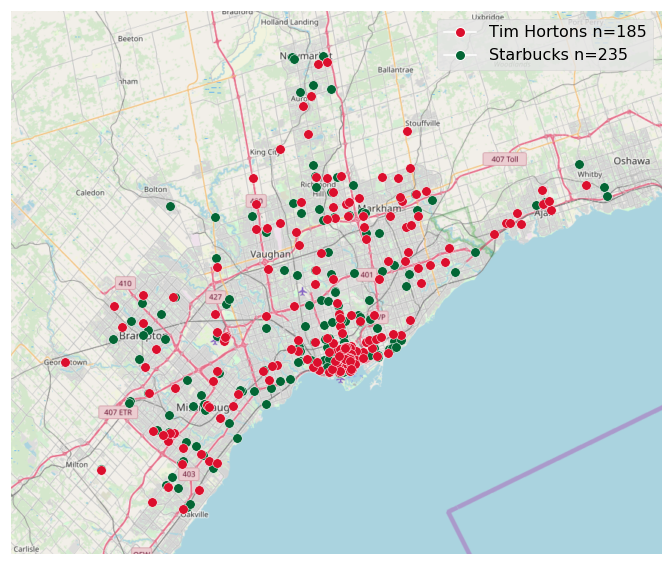

In [219]:
temp_star = gdf_star.to_crs(epsg=3857)
temp_tims = gdf_tims.to_crs(epsg=3857)

ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=90)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=90)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n=185',
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n=235',
                 markerfacecolor=colors[1], markersize=10),]


plt.legend(handles=points, fontsize=16)
plt.show()

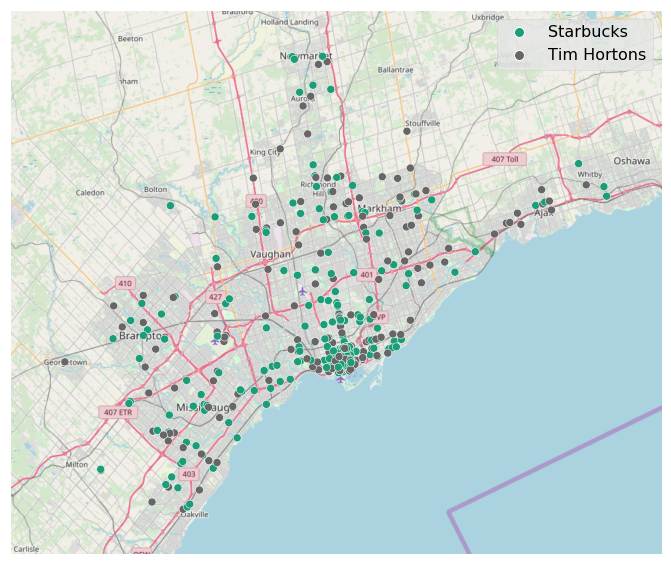

In [42]:
# Thematic colors for Tim Hortons and Starbucks
colors = ['#dc0f2d', '#036635']

ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.pointplot(gdf_coffee, ax=ax, hue='name', cmap='Dark2', legend=True, legend_kwargs={'fontsize': 16}, s=8,
              edgecolor='white')

plt.show()

In [132]:
gdf_coffee.crs

{'init': 'epsg:4326'}

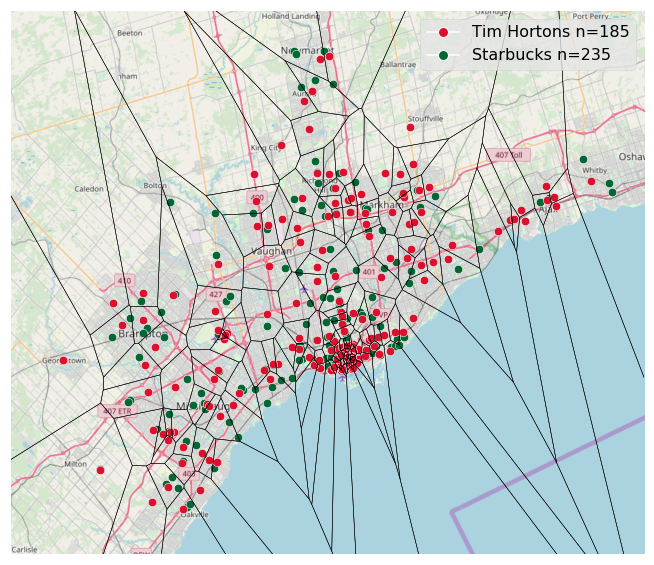

In [221]:
ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.voronoi(gdf_tims, ax=ax)
temp_star.plot(ax=ax, color=colors[1], edgecolor='white', markersize=70)
temp_tims.plot(ax=ax, color=colors[0], edgecolor='white', markersize=70)

points = [Line2D([0],[0], marker='o', color='white', label='Tim Hortons n=185',
                 markerfacecolor=colors[0], markersize=10),
         Line2D([0],[0], marker='o', color='white', label='Starbucks n=235',
                 markerfacecolor=colors[1], markersize=10),]


plt.legend(handles=points, fontsize=16)
plt.show()

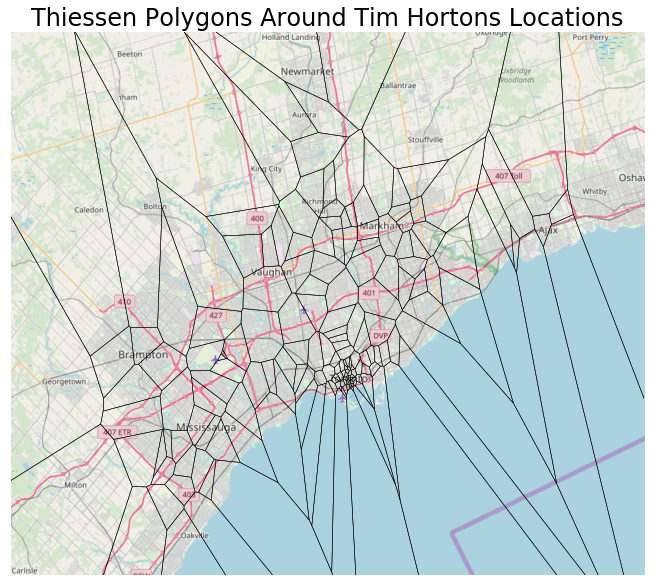

In [187]:
ax = gplt.webmap(gdf_coffee, projection=gcrs.WebMercator(), figsize=(15,10))
gplt.voronoi(gdf_tims, ax=ax)
#gplt.pointplot(gdf_coffee, ax=ax, hue='name', cmap='Dark2', legend=True, legend_kwargs={'fontsize': 16}, s=8,
              #edgecolor='white')
gdf_coffee.plot(ax=ax)

plt.title("Thiessen Polygons Around Tim Hortons Locations", fontsize=24)
plt.show()

In [69]:
# Extract coordinates of Tim Hortons locations as tuples so we can create a Voronoi object
points = []
for i, row in tims.iterrows():
    points.append((row.longitude, row.latitude))

# Outer Voronoi polygons are infinite in size, so we add 6 new points to bound as many as reasonably
# possible in finite polygons.
# We look at the max and min x,y values for the coordinates of Tim Hortons locations, and generate
# points that are slightly further out
edges = gdf_tims.total_bounds
points.append((edges[0]-0.01, edges[1]-0.01))
points.append((edges[0]-0.01, edges[3]+0.01))
points.append((edges[2]+0.01, edges[1]-0.01))
points.append((edges[2]+0.01, edges[3]+0.01))
points.append(((edges[0]+edges[2])/2, edges[1]-0.01))
points.append(((edges[0]+edges[2])/2, edges[3]+0.01))
points.append(((edges[0]-0.01, (edges[1] + edges[3])/2)))
points.append(((edges[2]+0.01, (edges[1] + edges[3])/2)))

# Create Voronoi object
vor = scp.spatial.Voronoi(points=points)

In [83]:
# Get the boundaries of finite polygons. Infinite polygons have a -1 entry in them.
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices
    if -1 not in line
]
# Create polygons based on lines, create DataFrame out of polygons
polygons = [pol for pol in polygonize(lines)]
pol_df = pd.DataFrame(polygons)
pol_df.columns=['polygon']

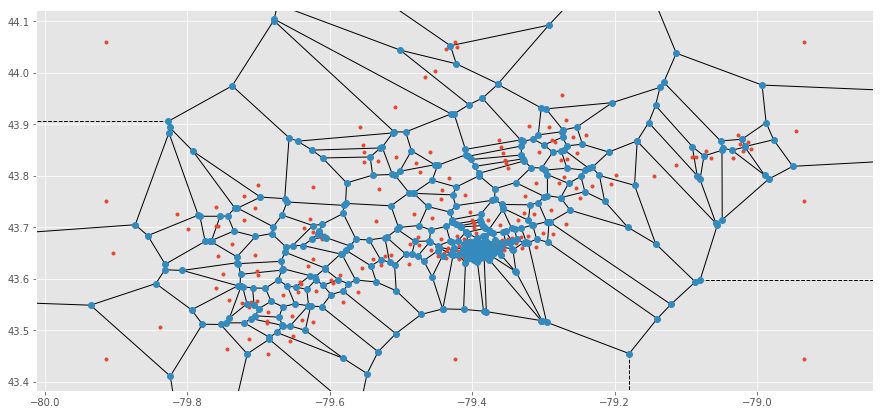

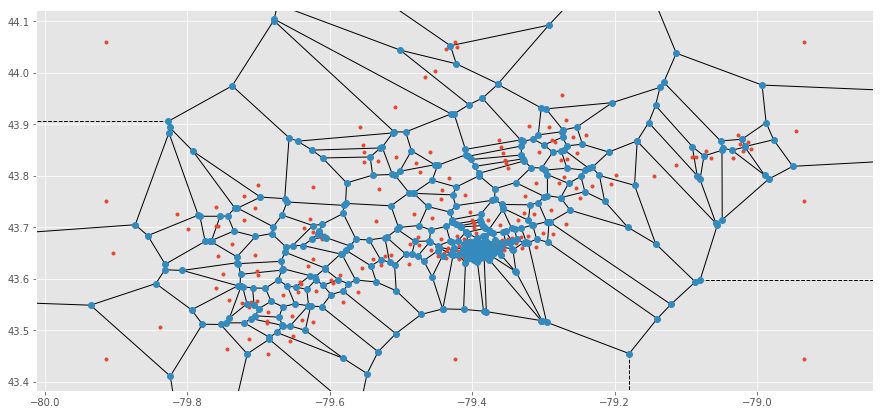

In [131]:
scp.spatial.voronoi_plot_2d(vor)

In [135]:
def get_poly_statistics(row: pd.Series) -> int:
    """Given a Pandas Series representing a row about a Voloronoi polygon, compute and return
    how many Starbucks locations are contained within it."""
    
    n_star = 0
    for i, star in starbucks.iterrows():
        # Count number of Starbucks in polygon
        if star.geometry.within(row.polygon):
            n_star += 1
        
    # Code adapted from https://stackoverflow.com/questions/51554602/how-do-i-get-the-area-of-a-geojson-polygon-with-python
    polygon = row.polygon
    geom_area = ops.transform(
    partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(
        proj='aea',
        lat1=polygon.bounds[1],
        lat2=polygon.bounds[3])),
    polygon)    
    return pd.Series([n_star, geom_area.area])

def get_n_starbucks(row: pd.Series) -> int:
    n_star = 0
    for i, star in starbucks.iterrows():
        # Count number of Starbucks in polygon
        if star.geometry.within(row.polygon):
            n_star += 1
    return n_star

def get_poly_area(row: pd.Series) -> int:
    polygon = row.polygon
    geom_area = ops.transform(
    partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(
        proj='aea',
        lat1=polygon.bounds[1],
        lat2=polygon.bounds[3], preserve_units=True)),
    polygon) 
    return geom_area.area
#pol_df[['n_starbucks', 'area_m2']] = pol_df.apply(lambda row: get_poly_statistics(row), axis=1)
#pol_df.n_starbucks = pol_df.apply(lambda row: int(row), axis=1)
pol_df['n_starbucks'] = pol_df.apply(lambda row: get_n_starbucks(row), axis=1)
pol_df['area_m2'] = pol_df.apply(lambda row: get_poly_area(row), axis=1)

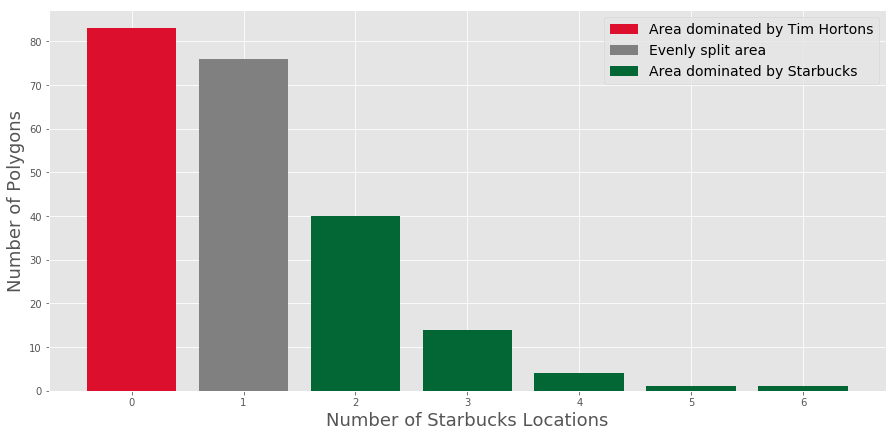

In [223]:
fig, ax = plt.subplots()

count_n = pol_df.groupby('n_starbucks').count()

ax = plt.bar(x=count_n.index, height=count_n.polygon,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)    

#plt.suptitle("Number of Starbucks Locations in Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Number of Polygons", fontsize=18)
plt.xticks([0,1,2,3,4,5,6])
plt.show()

The majority of of Tim Hortons locations are situated such that they are the closest neighbour to just a single or no Starbucks locations - this is a favourable situation for Tim Hortons, since this means that for some region around each location there is usually just one or none Starbucks locations. Only for very few Tim Hortons locations is there a situation where there's a lot of Starbucks locations around them, meaning that Starbucks is dominating that are.

However, it may just be that this is happening since the areas with one or no Starbucks locations are very small, so we should investigate the area sizes for our polygons.

In [150]:
pol_df.groupby('n_starbucks').sum()

area_m2
n_starbucks              
0            3.000630e+09
1            1.635202e+09
2            3.730377e+09
3            1.084457e+09
4            3.316363e+07
5            1.075380e+07
6            1.331911e+06

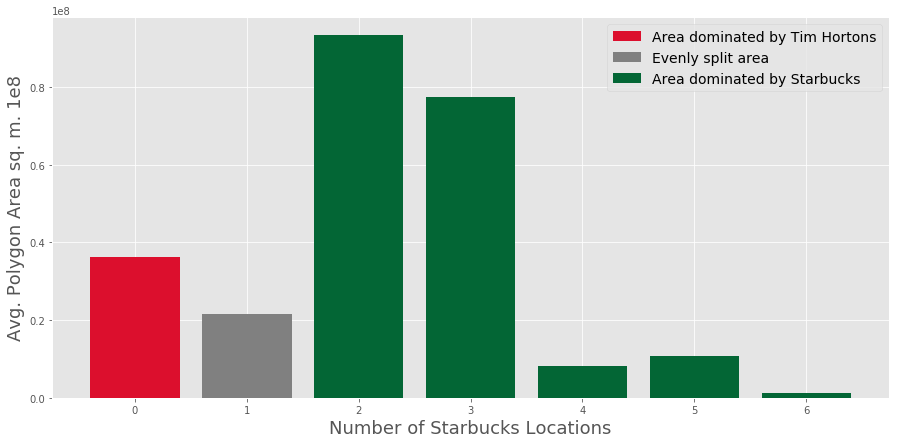

In [224]:
mean_area = pol_df.groupby('n_starbucks').mean().reset_index()

ax = plt.bar(x=mean_area.index, height=mean_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)

#plt.suptitle("Average Area of Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations Per N of Starbucks in Polygon")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Avg. Polygon Area sq. m. 1e8", fontsize=18)
plt.show()

This graph provides us with a somewhat different interpretation. The areas where there are 2 or 3 Starbucks locations per a single Tim Hortons are significantly larger in size than those where Tim Hortons locations dominate. The areas where there are 4 or more Starbucks locations per a single Tim Hortons location are very small in size - these are likely the downtown areas of the cities in the GTA.



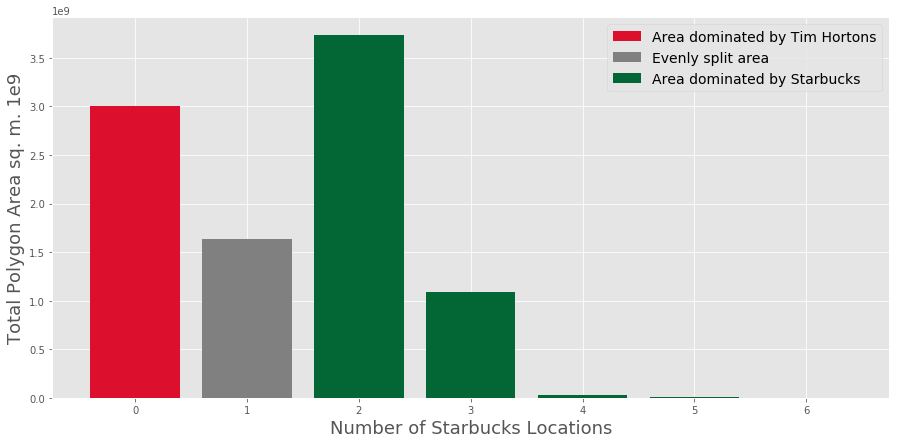

In [226]:
sum_area = pol_df.groupby('n_starbucks').sum().reset_index()

ax = plt.bar(x=sum_area.index, height=sum_area.area_m2,
             color=(colors[0], 'gray', colors[1], colors[1], colors[1], colors[1], colors[1]))

legend_elements= [Patch(facecolor=colors[0], label='Area dominated by Tim Hortons'),
                  Patch(facecolor='gray', label = 'Evenly split area'),
                  Patch(facecolor=colors[1], label = 'Area dominated by Starbucks')]

plt.legend(handles=legend_elements, fontsize=14)

#plt.suptitle("Summed Area of Thiessen Polygons", fontsize=24)
#plt.title("Around Tim Hortons Locations Per N of Starbucks in Polygon")
plt.xlabel("Number of Starbucks Locations", fontsize=18)
plt.ylabel("Total Polygon Area sq. m. 1e9", fontsize=18)
plt.show()